In [5]:
%config Completer.use_jedi = False

In [6]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.LogDataHandling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK75_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
#dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
#dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

mutation_arange = [np.round(x,2) for x in np.arange(0.1,1,0.2)]


startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,heterogeneousFleet=True)

In [7]:
    
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_plot2(data,variable_field,between_fields,path=None,save=False):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1,figsize=(15,15))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df.where(summary_df.reject == True,inplace=True)
    summary_df.dropna(inplace=True)
  
    
    optimal_params = extractOptimalParameters2(data,summary_df,1)
    if len(optimal_params) > 0:
        
        optimal_group = int(optimal_params.head(1)[between_fields]) or None
    else:
        optimal_group = None
    tukey.plot_simultaneous(figsize=(15,15),ax=ax,comparison_name =optimal_group )
    #ax.set_xlabel("Euclidean distance",fontsize=24)
    plt.yticks(range(0,45,2),range(0,45,2))
    #plt.yticks(range(0,5),range(0,5))
    ax.set_xlabel("Objective sum",fontsize=24)
    ax.set_ylabel("Parameter Group",fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    
    plt.title("")
    plt.savefig("anova_plot_{}.pdf".format(data.algorithm),bbox_inches='tight')
    plt.show()
    
    
    
    return summary_df ,fig, tukey
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov
def extractOptimalParameters2(resultsDataFrame,tukeyResult,amount=5):
    optimalParamGroups = tukeyResult.sort_values(by='meandiff').head(amount).group2
    resultDF = pd.DataFrame(columns=resultsDataFrame.columns)
    for group in optimalParamGroups:
        resultDF = pd.concat([resultDF,(resultsDataFrame.where(resultsDataFrame["Parameter Group"] == np.float(group))).dropna()],axis=0)
    return resultDF


In [109]:

def get_sorted_df(dataFrames):
    optimal_params_DF=pd.DataFrame()
    datasetNames = ["UK25_2","UK25_4","UK25_8","UK50_1","SA_50_2","SA_50_4","UK75_1","UK75_3","UK75_6"]
    for dataframe,datasetName in zip(dataFrames,datasetNames):
        
        dataframe_optimal = dataframe.groupby(by=["Parameter Group"]).mean().sort_values(by=["summation_minmax"]).head(1)
        dataframe_optimal["dataset"] = datasetName
        optimal_params_DF = pd.concat([optimal_params_DF,dataframe_optimal])
    return optimal_params_DF#.groupby("Parameter Group").head()
    


In [161]:
def process_log_data(dataframes):
    for df in dataframes:
        add_final_fitness_columns(df)
        expand_parameter_colums(df)
        add_distance_to_origin(df)
        df["vehicle_amount"] = df.vehicle_route_time.apply(len)
        df["total_route_time"] = df.vehicle_route_time.apply(sum)/(60**2)

        df["gini_index"] = get_gini_coefficients(df) #* np.array([math.ceil(df.fuel_consumption[0][0] /100) * 100]*45*30)
        gini_scale =  np.array([math.ceil(df.fuel_consumption[0][0] /100) * 100]*45*30)
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption-min_fuel_consumption)

        summation = df.fuel_consumption_final + df.total_route_time + (df.gini_index*gini_scale)
        max_distance_to_origin = max(summation)
        min_distance_to_origin = min(summation)
        df["summation_minmax"] = (( df.fuel_consumption_final + df.total_route_time + (df.gini_index * gini_scale)) - min_distance_to_origin)/(max_distance_to_origin-min_distance_to_origin)
    return pd.concat(dataframes)
    

# NSGAII

In [207]:
NSGA2_25_2 = pd.read_csv("parameter_data/multi_objective/UK25_2/NSGA2.csv")
NSGA2_25_4 = pd.read_csv("parameter_data/multi_objective/UK25_4/NSGA2.csv")
NSGA2_25_8 = pd.read_csv("parameter_data/multi_objective/UK25_8/NSGA2.csv")
NSGA2_50_1 = pd.read_csv("parameter_data/multi_objective/UK50_1/NSGA2.csv")
NSGA2_50_2 = pd.read_csv("parameter_data/multi_objective/UK50_2/NSGA2.csv")
NSGA2_50_4 = pd.read_csv("parameter_data/multi_objective/UK50_4/NSGA2.csv")
NSGA2_75_1 = pd.read_csv("parameter_data/multi_objective/UK75_1/NSGA2.csv")
NSGA2_75_3 = pd.read_csv("parameter_data/multi_objective/UK75_3/NSGA2.csv")
NSGA2_75_6 = pd.read_csv("parameter_data/multi_objective/UK75_6/NSGA2.csv")


combined_NSGA2 = [NSGA2_25_2,NSGA2_25_4,NSGA2_25_8,NSGA2_50_1,NSGA2_50_2,NSGA2_50_4,NSGA2_75_1,NSGA2_75_3,NSGA2_75_6]

    
NSGA2_data =process_log_data(combined_NSGA2)# pd.concat(combined_NSGA2)
    

In [208]:
optimal_params_NSGA2 = get_sorted_df(combined_NSGA2)
optimal_params_NSGA2

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
43.0,14.5,212.127740,73.256887,199.028333,0.9,0.75,20.0,3.033333,9.284546,0.034223,0.168032,0.095078,UK25_2
26.0,14.5,456.157514,242.082003,386.512222,0.5,0.75,30.0,5.000000,19.694130,0.292580,0.338541,0.233068,UK25_4
35.0,14.5,270.345194,110.579055,246.448333,0.7,0.75,30.0,3.933333,14.287880,0.054192,0.276424,0.132461,UK25_8
35.0,14.5,365.066579,216.592685,291.668333,0.7,0.75,30.0,9.000000,28.160852,0.148371,0.207931,0.161730,UK50_1
44.0,14.5,333.574290,182.954801,278.454444,0.9,0.75,30.0,6.333333,23.987926,0.089086,0.170437,0.145472,SA_50_2
44.0,14.5,307.054127,176.016450,251.550556,0.9,0.75,30.0,8.000000,24.118241,0.177024,0.182904,0.194083,SA_50_4
35.0,14.5,668.933118,490.004967,454.887222,0.7,0.75,30.0,10.500000,52.863343,0.209852,0.142429,0.149040,UK75_1
35.0,14.5,423.794668,238.950546,349.827222,0.7,0.75,30.0,12.400000,35.676833,0.276305,0.054234,0.050812,UK75_3
35.0,14.5,503.786474,341.904013,367.618333,0.7,0.75,30.0,11.866667,40.055426,0.222053,0.115532,0.161287,UK75_6


In [209]:
optimal_params_NSGA2.total_route_time*60

Parameter Group
43.0     557.072778
26.0    1181.647778
35.0     857.272778
35.0    1689.651111
44.0    1439.275556
44.0    1447.094444
35.0    3171.800556
35.0    2140.610000
35.0    2403.325556
Name: total_route_time, dtype: float64

In [210]:
NSGA2_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
35.0,14.5,394.719764,230.248843,315.470123,0.7,0.75,30.0,7.792593,27.598734,0.169655,0.180846,0.152172
44.0,14.5,394.549807,232.027056,313.870988,0.9,0.75,30.0,7.807407,27.656926,0.169821,0.191915,0.162941
23.0,14.5,393.183257,232.264437,312.041235,0.5,0.50,30.0,7.900000,27.729932,0.169564,0.195492,0.164302
32.0,14.5,394.888941,231.665746,314.651420,0.7,0.50,30.0,7.785185,27.657381,0.171347,0.190229,0.164948
26.0,14.5,394.751412,231.965144,314.398272,0.5,0.75,30.0,7.907407,27.697510,0.172403,0.193262,0.169055
43.0,14.5,400.142105,232.207705,320.950123,0.9,0.75,20.0,7.785185,27.690351,0.174832,0.193223,0.174063
41.0,14.5,399.311654,233.237367,318.732222,0.9,0.50,30.0,7.807407,27.775487,0.174883,0.195847,0.176894
34.0,14.5,398.892268,233.293793,317.974198,0.7,0.75,20.0,7.822222,27.810545,0.175353,0.192250,0.177154
29.0,14.5,399.074744,233.710866,318.314321,0.7,0.25,30.0,7.792593,27.827881,0.173234,0.203750,0.181779


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



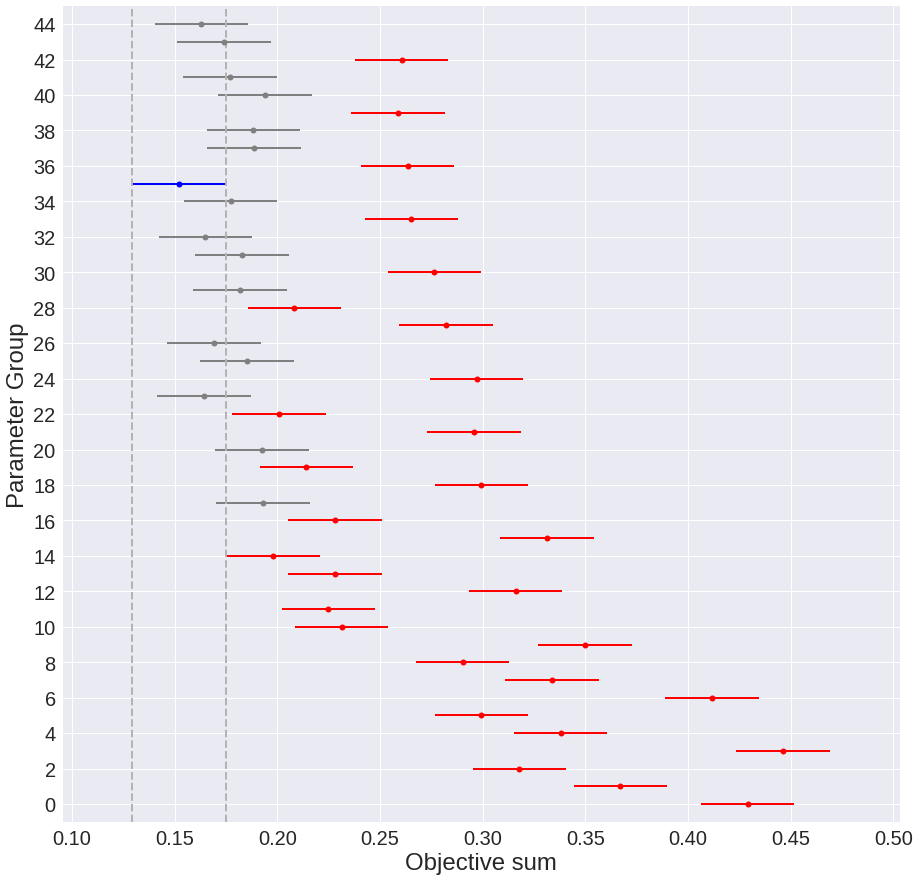

In [211]:
NSGA2_data.algorithm="NSGA2"
nsga2_data_tukey,fig,t = anova_plot2(NSGA2_data,'summation_minmax','Parameter Group')

# NSGAIII

In [212]:
NSGA3_25_2 = pd.read_csv("parameter_data/multi_objective/UK25_2/NSGA3.csv")
NSGA3_25_4 = pd.read_csv("parameter_data/multi_objective/UK25_4/NSGA3.csv")
NSGA3_25_8 = pd.read_csv("parameter_data/multi_objective/UK25_8/NSGA3.csv")
NSGA3_50_1 = pd.read_csv("parameter_data/multi_objective/UK50_1/NSGA3.csv")
NSGA3_50_2 = pd.read_csv("parameter_data/multi_objective/UK50_2/NSGA3.csv")
NSGA3_50_4 = pd.read_csv("parameter_data/multi_objective/UK50_4/NSGA3.csv")
NSGA3_75_1 = pd.read_csv("parameter_data/multi_objective/UK75_1/NSGA3.csv")
NSGA3_75_3 = pd.read_csv("parameter_data/multi_objective/UK75_3/NSGA3.csv")
NSGA3_75_6 = pd.read_csv("parameter_data/multi_objective/UK75_6/NSGA3.csv")


combined_NSGA3 = [NSGA3_25_2,NSGA3_25_4,NSGA3_25_8,NSGA3_50_1,NSGA3_50_2,NSGA3_50_4,NSGA3_75_1,NSGA3_75_3,NSGA3_75_6]

NSGA3_data = process_log_data(combined_NSGA3)
   
    

In [213]:
get_sorted_df(combined_NSGA3)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
44.0,14.5,215.359048,71.781444,202.973333,0.9,0.75,30.0,3.000000,9.167657,0.041483,0.172303,0.083598,UK25_2
35.0,14.5,455.809812,242.543551,385.853889,0.7,0.75,30.0,5.000000,19.797778,0.289503,0.126577,0.094704,UK25_4
44.0,14.5,265.552331,110.219124,241.538889,0.9,0.75,30.0,4.000000,14.257454,0.055500,0.237854,0.130267,UK25_8
26.0,14.5,352.858929,219.170470,274.464444,0.5,0.75,30.0,9.200000,28.550435,0.133455,0.189119,0.190371,UK50_1
32.0,14.5,340.353990,179.834810,288.593889,0.7,0.50,30.0,6.166667,23.676259,0.095096,0.106455,0.126621,SA_50_2
35.0,14.5,306.308034,175.984776,250.593889,0.7,0.75,30.0,8.033333,24.065787,0.179671,0.187302,0.164975,SA_50_4
44.0,14.5,677.684926,495.251277,461.597222,0.9,0.75,30.0,10.566667,53.599185,0.195950,0.158681,0.173236,UK75_1
44.0,14.5,422.413113,240.645004,346.893333,0.9,0.75,30.0,12.133333,35.621287,0.272547,0.043196,0.050440,UK75_3
23.0,14.5,488.845024,346.006917,344.386111,0.5,0.50,30.0,11.866667,40.277009,0.205441,0.115143,0.131567,UK75_6


In [214]:
get_sorted_df(combined_NSGA3).total_route_time * 60

Parameter Group
44.0     550.059444
35.0    1187.866667
44.0     855.447222
26.0    1713.026111
32.0    1420.575556
35.0    1443.947222
44.0    3215.951111
44.0    2137.277222
23.0    2416.620556
Name: total_route_time, dtype: float64

In [215]:
NSGA3_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
44.0,14.5,392.220006,232.211482,310.857346,0.9,0.75,30.0,7.814815,27.741996,0.162919,0.159608,0.136005
35.0,14.5,394.009917,233.261673,311.674938,0.7,0.75,30.0,7.840741,27.817628,0.167448,0.152393,0.145086
32.0,14.5,399.033469,233.441134,317.663827,0.7,0.50,30.0,7.774074,27.733260,0.171210,0.156926,0.156186
41.0,14.5,398.393794,234.751415,316.218210,0.9,0.50,30.0,7.825926,27.876514,0.171480,0.164850,0.159287
26.0,14.5,394.244830,235.210215,310.103951,0.5,0.75,30.0,7.948148,28.055177,0.168764,0.161888,0.161286
40.0,14.5,399.290170,235.898455,316.420370,0.9,0.50,20.0,7.811111,28.026275,0.167357,0.172525,0.162537
38.0,14.5,399.423383,235.236804,317.116543,0.9,0.25,30.0,7.822222,27.910297,0.170582,0.167637,0.163946
43.0,14.5,400.331005,237.049006,316.274198,0.9,0.75,20.0,7.837037,28.196039,0.166015,0.172483,0.164808
29.0,14.5,398.579994,235.566308,315.561667,0.7,0.25,30.0,7.874074,28.036274,0.172389,0.167274,0.169503


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



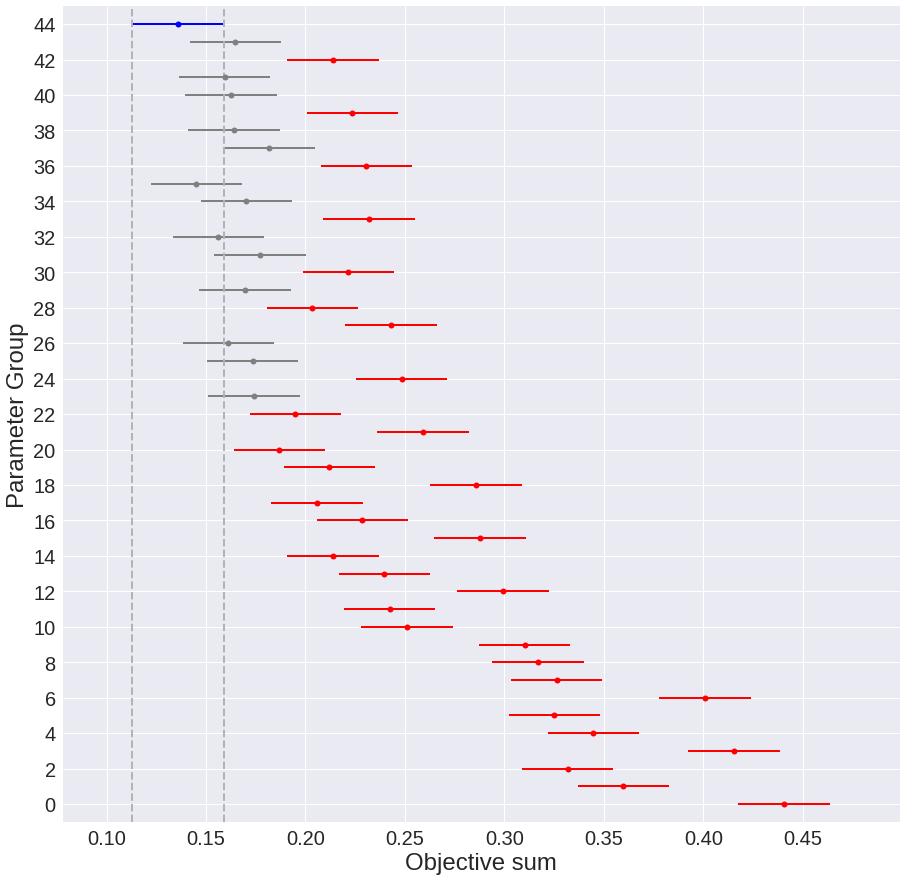

In [216]:
NSGA3_data.algorithm="NSGA3"
nsga3_data_tukey,fig,t = anova_plot2(NSGA3_data,'summation_minmax','Parameter Group')

# UNSGAII

In [217]:
UNSGA3_25_2 = pd.read_csv("parameter_data/multi_objective/UK25_2/UNSGA3.csv")
UNSGA3_25_4 = pd.read_csv("parameter_data/multi_objective/UK25_4/UNSGA3.csv")
UNSGA3_25_8 = pd.read_csv("parameter_data/multi_objective/UK25_8/UNSGA3.csv")
UNSGA3_50_1 = pd.read_csv("parameter_data/multi_objective/UK50_1/UNSGA3.csv")
UNSGA3_50_2 = pd.read_csv("parameter_data/multi_objective/UK50_2/UNSGA3.csv")
UNSGA3_50_4 = pd.read_csv("parameter_data/multi_objective/UK50_4/UNSGA3.csv")
UNSGA3_75_1 = pd.read_csv("parameter_data/multi_objective/UK75_1/UNSGA3.csv")
UNSGA3_75_3 = pd.read_csv("parameter_data/multi_objective/UK75_3/UNSGA3.csv")
UNSGA3_75_6 = pd.read_csv("parameter_data/multi_objective/UK75_6/UNSGA3.csv")


combined_UNSGA3 = [UNSGA3_25_2,UNSGA3_25_4,UNSGA3_25_8,UNSGA3_50_1,UNSGA3_50_2,UNSGA3_50_4,UNSGA3_75_1,UNSGA3_75_3,UNSGA3_75_6]

UNSGA3_data = process_log_data(combined_UNSGA3)
    

In [218]:
get_sorted_df(combined_UNSGA3)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
43.0,14.5,211.376971,72.623283,198.351667,0.9,0.75,20.0,3.066667,9.219398,0.039772,0.165134,0.106904,UK25_2
26.0,14.5,459.892608,243.577643,390.020000,0.5,0.75,30.0,5.000000,19.800546,0.292498,0.110417,0.101412,UK25_4
44.0,14.5,267.615059,108.877233,244.392778,0.9,0.75,30.0,4.000000,14.064620,0.073024,0.312852,0.158377,UK25_8
41.0,14.5,362.854291,216.046117,289.024444,0.9,0.50,30.0,8.933333,28.152611,0.149787,0.186444,0.151378,UK50_1
38.0,14.5,344.155037,179.193276,293.531111,0.9,0.25,30.0,6.133333,23.595685,0.105967,0.090537,0.099423,SA_50_2
44.0,14.5,309.000675,177.976088,252.365000,0.9,0.75,30.0,8.033333,24.374009,0.173616,0.208929,0.166665,SA_50_4
44.0,14.5,687.401257,509.289630,460.727222,0.9,0.75,30.0,10.533333,54.796963,0.188143,0.195602,0.205072,UK75_1
35.0,14.5,423.074897,240.691230,347.493333,0.7,0.75,30.0,12.333333,35.685380,0.272969,0.048572,0.057318,UK75_3
35.0,14.5,485.634541,343.115291,342.675556,0.7,0.75,30.0,11.933333,39.919454,0.215198,0.086964,0.131676,UK75_6


In [219]:
UNSGA3_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
44.0,14.5,395.952017,233.191125,314.625802,0.9,0.75,30.0,7.822222,27.861127,0.168653,0.162644,0.138190
35.0,14.5,397.878735,234.678382,315.371481,0.7,0.75,30.0,7.818519,28.018335,0.167848,0.174220,0.148938
43.0,14.5,401.795938,238.030854,317.434444,0.9,0.75,20.0,7.837037,28.308365,0.165491,0.179380,0.151203
41.0,14.5,400.634249,236.793290,317.052222,0.9,0.50,30.0,7.851852,28.143931,0.168954,0.173533,0.155003
32.0,14.5,399.404840,237.154744,314.700000,0.7,0.50,30.0,7.840741,28.160798,0.171529,0.173924,0.155126
38.0,14.5,405.051101,236.278018,323.035988,0.9,0.25,30.0,7.800000,28.097827,0.175228,0.168491,0.158569
26.0,14.5,401.431690,235.140451,319.190000,0.5,0.75,30.0,7.907407,28.025633,0.176977,0.162598,0.159550
34.0,14.5,405.376352,239.731134,320.119815,0.7,0.75,20.0,7.837037,28.501296,0.169088,0.183662,0.165236
40.0,14.5,404.413732,238.284684,320.420000,0.9,0.50,20.0,7.866667,28.334835,0.173001,0.178310,0.166607


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



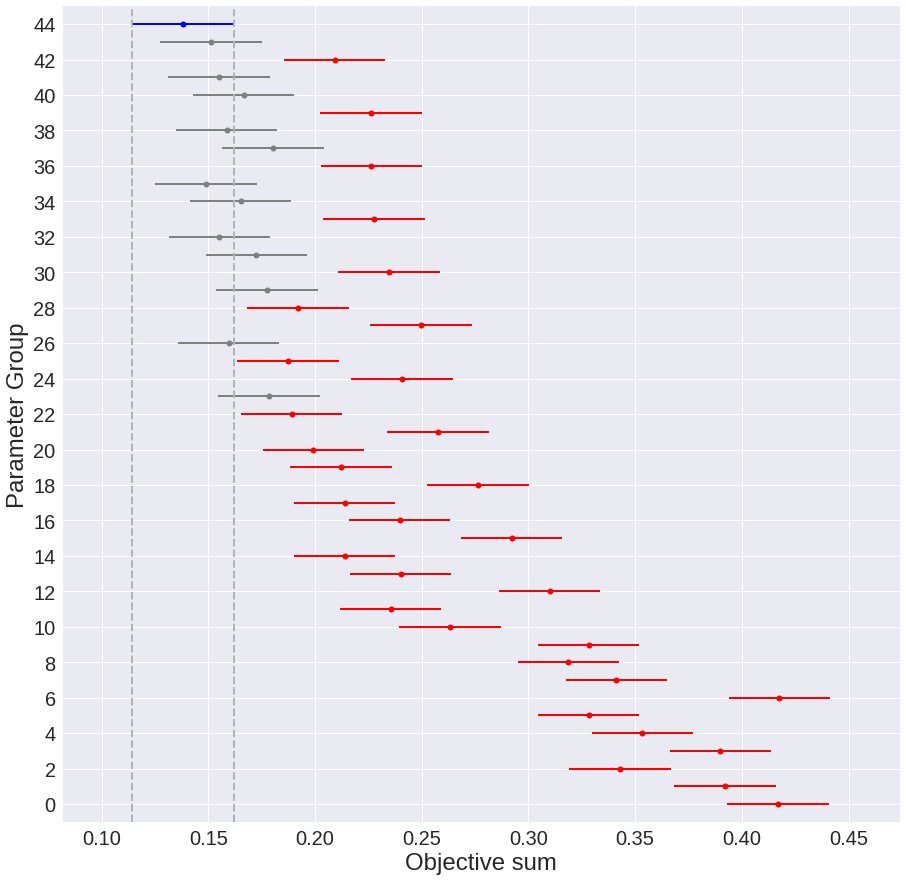

In [220]:
UNSGA3_data.algorithm="UNSGA3"
Unsga3_data_tukey,fig,t = anova_plot2(UNSGA3_data,'summation_minmax','Parameter Group')

# IBEA

In [221]:
IBEA_25_2 = pd.read_csv("parameter_data/multi_objective/UK25_2/IBEA.csv")
IBEA_25_4 = pd.read_csv("parameter_data/multi_objective/UK25_4/IBEA.csv")
IBEA_25_8 = pd.read_csv("parameter_data/multi_objective/UK25_8/IBEA.csv")
IBEA_50_1 = pd.read_csv("parameter_data/multi_objective/UK50_1/IBEA.csv")
IBEA_50_2 = pd.read_csv("parameter_data/multi_objective/UK50_2/IBEA.csv")
IBEA_50_4 = pd.read_csv("parameter_data/multi_objective/UK50_4/IBEA.csv")
IBEA_75_1 = pd.read_csv("parameter_data/multi_objective/UK75_1/IBEA.csv")
IBEA_75_3 = pd.read_csv("parameter_data/multi_objective/UK75_3/IBEA.csv")
IBEA_75_6 = pd.read_csv("parameter_data/multi_objective/UK75_6/IBEA.csv")

combined_IBEA = [IBEA_25_2,IBEA_25_4,IBEA_25_8,IBEA_50_1,IBEA_50_2,IBEA_50_4,IBEA_75_1,IBEA_75_3,IBEA_75_6]

IBEA_data =process_log_data(combined_IBEA)
    

In [222]:
IBEA_data.groupby("Parameter Group").mean().sort_values(by=["summation_minmax"]).head(10)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax
Parameter Group,,,,,,,,,,,,
35.0,14.5,379.598965,223.832520,302.220123,0.7,0.75,30.0,7.733333,27.299159,0.152941,0.194131,0.168218
32.0,14.5,381.057053,224.539350,303.352716,0.7,0.50,30.0,7.718519,27.333419,0.153685,0.194814,0.171013
31.0,14.5,381.743590,224.388359,304.599074,0.7,0.50,20.0,7.785185,27.450401,0.153507,0.198127,0.174695
43.0,14.5,381.692029,225.609983,303.347407,0.9,0.75,20.0,7.777778,27.504656,0.152214,0.205000,0.177187
41.0,14.5,383.618078,225.157334,305.981975,0.9,0.50,30.0,7.714815,27.382220,0.156263,0.194485,0.178197
40.0,14.5,382.790770,224.853970,305.564568,0.9,0.50,20.0,7.714815,27.398580,0.154295,0.201056,0.180152
34.0,14.5,380.932489,224.400699,303.726420,0.7,0.75,20.0,7.796296,27.365604,0.154793,0.202760,0.180954
42.0,14.5,379.987623,226.489110,300.625432,0.9,0.75,10.0,7.822222,27.773343,0.147488,0.218964,0.181296
26.0,14.5,383.862873,224.271513,307.340556,0.5,0.75,30.0,7.707407,27.275901,0.158402,0.194757,0.181531


In [223]:
get_sorted_df(combined_IBEA)

,Unnamed: 0,distance_to_origin,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,vehicle_amount,total_route_time,gini_index,fuel_consumption_final_minmax,summation_minmax,dataset
Parameter Group,,,,,,,,,,,,,
41.0,14.5,212.976267,71.133072,200.679444,0.9,0.50,30.0,3.000000,9.227824,0.034000,0.153710,0.112453,UK25_2
26.0,14.5,450.830153,241.015251,380.933889,0.5,0.75,30.0,5.000000,19.773537,0.284402,0.166431,0.218191,UK25_4
31.0,14.5,262.365310,108.763644,238.745556,0.7,0.50,20.0,4.000000,14.324278,0.044236,0.213566,0.056553,UK25_8
35.0,14.5,337.056666,213.803431,258.328333,0.7,0.75,30.0,9.333333,28.262287,0.124847,0.259696,0.166157,UK50_1
31.0,14.5,330.572650,178.484628,278.041667,0.7,0.50,20.0,6.133333,23.966528,0.061612,0.205500,0.167627,SA_50_2
35.0,14.5,302.161687,173.707811,247.231111,0.7,0.75,30.0,8.000000,24.164602,0.167089,0.178786,0.134631,SA_50_4
30.0,14.5,639.200173,446.275355,457.078333,0.7,0.50,10.0,9.833333,50.359611,0.186974,0.162056,0.186994,UK75_1
35.0,14.5,407.859086,241.303614,327.756111,0.7,0.75,30.0,12.800000,36.201167,0.251827,0.112416,0.080104,UK75_3
32.0,14.5,470.449538,334.492646,330.199444,0.7,0.50,30.0,11.700000,39.848620,0.187202,0.195328,0.215637,UK75_6


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



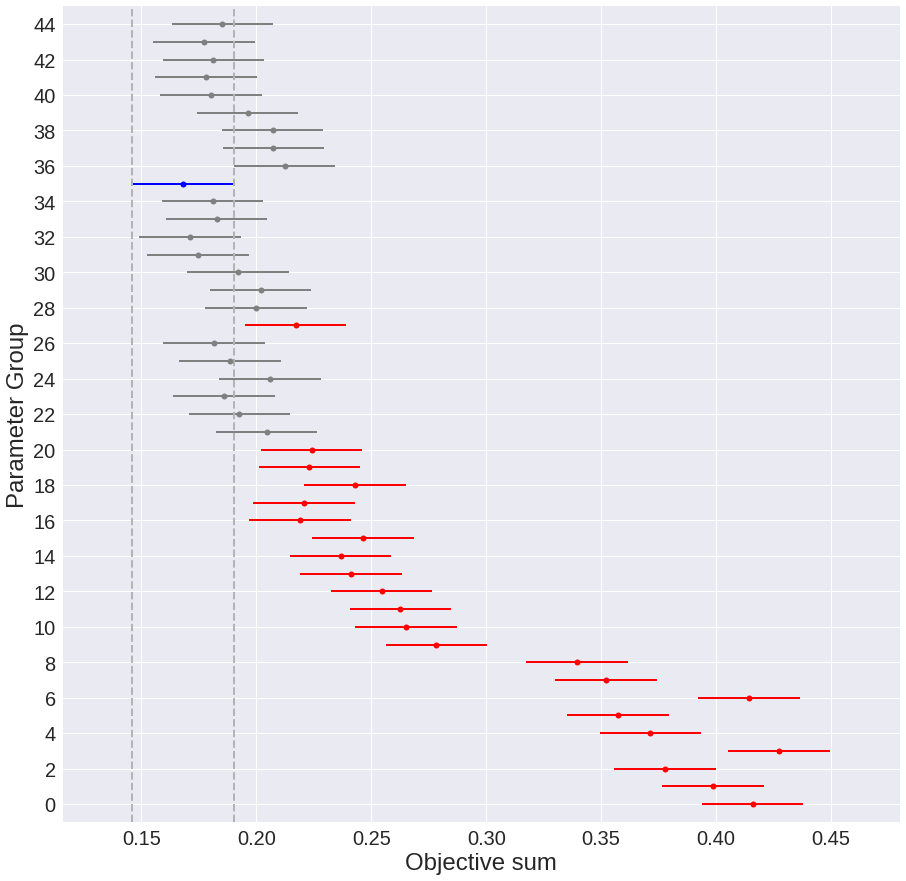

In [224]:
IBEA_data.algorithm="IBEA"
IBEA_data_tukey,fig,t = anova_plot2(IBEA_data,'summation_minmax','Parameter Group')